In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tutorial_path = "drive/MyDrive/"
dependencies = f'{tutorial_path}dependencies/'

In [ ]:
!pip install numpy pandas pickle seaborn music21 iteration_utilities
!pip install git+https://github.com/quadrismegistus/prosodic.git
!apt install musescore3

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
  Cloning https://github.com/quadrismegistus/prosodic.git to /tmp/pip-req-build-qi78o1tc
  Running command git clone --filter=blob:none --quiet https://github.com/quadrismegistus/prosodic.git /tmp/pip-req-build-qi78o1tc
  Resolved https://github.com/quadrismegistus/prosodic.git to commit d8944c49428bb884227847e3f159cdbaed7f35eb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/dmort27/syllabiphon to /tmp/pip-install-0kzxloe7/syllabiphon_acd29567ac9640b6a6c5dce585c87e0d
  Running command git clone --filter=blob:none --quiet https://github.com/dmort27/syllabiphon /tmp/pip-install-0kzxloe7/syllabiphon_acd29567ac9640b6a6c5dce585c87e0d
  Resolved https://github.com/dmort27/syllabiphon to commit 7cb3452d77e357bb8dcdf7a7e7d8a37babe235b6
  Preparing metadata (setup.py) ... do

In [ ]:
!pip install iteration_utilities

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import music21

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists

from music21 import midi, note, stream, instrument, meter, key
import itertools
import random

import string

In [ ]:
def helpers_simplify_score_for_rhythm_analysis(sample_score_tmp):

    # remove chord charts, metronome mark, dynamics
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.harmony.ChordSymbol):
                    measure.remove(event)
                if isinstance(event, music21.tempo.MetronomeMark):
                    measure.remove(event)
                if isinstance(event, music21.dynamics.Dynamic):
                    measure.remove(event)
                if isinstance(event, music21.key.KeySignature):
                    measure.remove(event)

    # combine voice tracks intra-staff (done by extracted staffs and recombining)
    chordified_treble = sample_score_tmp.parts[0].chordify()
    chordified_bass = sample_score_tmp.parts[1].chordify()
    sample_score = music21.stream.Score()
    sample_score.insert(0, chordified_treble)
    sample_score.insert(0, chordified_bass)

    # cast all single-note chord objects (created by chordify) as note objects so students see more typical music21 score object structure
    staff_count = 0
    for part in sample_score.parts:
        staff_count += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.chord.Chord): # and len(event.notes) == 1:
                    note_version = music21.note.Note()
                    if staff_count == 1:
                        note_version.pitch = music21.pitch.Pitch('C4')
                    elif staff_count == 2:
                        note_version.pitch = music21.pitch.Pitch('C3')
                    note_version.duration = event.duration
                    start_found = 0
                    continue_found = 0
                    none_found = 0
                    all_ties_stop = 1
                    for nte in event.notes:
                        try:
                            curr_tie_obj = nte.tie.type
                        except:
                            curr_tie_obj = None
                        if (curr_tie_obj == 'start'):
                            start_found = 1
                        if (curr_tie_obj == 'continue'):
                            continue_found = 1
                        if (curr_tie_obj is None):
                            none_found = 1
                        if (curr_tie_obj != 'stop'):
                            all_ties_stop = 0
                    if start_found == 1:
                        note_version.tie = music21.tie.Tie('start')
                    elif none_found == 1:
                        note_version.tie = None
                    elif all_ties_stop == 1:
                        note_version.tie = music21.tie.Tie('stop')
                    elif continue_found == 1:
                        note_version.tie = music21.tie.Tie('continue')
                    note_version.offset = event.offset
                    note_version.articulations = event.articulations
                    note_version.expressions = event.expressions
                    measure.replace(event, note_version)

    # fix instances where tie start leads to tie None (should be no tie but previous loop isn't built to observe two consecutive elements)
    # the ties are a pain >:"{
    for part in sample_score.parts:
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)-1):
                curr_event = measure[i]
                next_event = measure[i+1]
                if isinstance(curr_event, music21.note.Note) and isinstance(next_event, music21.note.Note):
                    try:
                        curr_tie = curr_event.tie.type
                    except:
                        curr_tie = None
                    try:
                        next_tie = next_event.tie.type
                    except:
                        next_tie = None
                    if (curr_tie == 'start' or curr_tie == 'continue') and (next_tie == 'start' or next_tie is None):
                        measure[i].tie = music21.tie.Tie('stop')
                if isinstance(curr_event, music21.note.Rest):
                    measure[i].tie = None

    # combine tied notes intra-staff
    for part in sample_score.parts:
        active_tie = 0
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)):
                if isinstance(measure[i], music21.note.Note):
                    if measure[i].tie is not None:
                        if measure[i].tie.type == "start":
                            active_tie = 1
                        elif measure[i].tie.type == "stop" and active_tie == 1:
                            active_tie = 0
                        elif measure[i].tie.type == "stop" and active_tie == 0:
                            measure[i].tie = None

    treble = sample_score.parts[0]
    for measure in treble.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    bass = sample_score.parts[1]
    for measure in bass.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    sample_score = music21.stream.Score()
    sample_score.insert(0, treble)
    sample_score.insert(0, bass)

    # deciding against repeat expands for now due to issues with measure number

    return sample_score

In [ ]:
data=[]

for root, dirs, files in os.walk("drive/MyDrive/Chopin"):  #replace filename
    for name in files:
        if name.endswith((".musicxml")):
            xml_data = music21.converter.parse(os.path.join(root, name))
            data.append(xml_data)

In [219]:


rhythm_data_list = {}
for el in data:
    sample_score = helpers_simplify_score_for_rhythm_analysis(el)
    firstStaff = True
    for staff in sample_score.parts:
        if firstStaff:
          staff_name = "treble"
          firstStaff = False
        else:
          staff_name = "bass"
        # staff_name = staff.elements[1].clef.name
        global_onset = 0
        time_sig = sample_score.flat.getElementsByClass('TimeSignature')[0].ratioString
        for measure in staff.getElementsByClass('Measure'):
            for event in measure.recurse():
                label = ""
                if isinstance(event, music21.note.Note):
                    label = "sounded"
                if isinstance(event, music21.note.Rest):
                    label = "unsounded"
                try:
                    tie_info = "tie_" + event.tie.type
                except:
                    tie_info = ""
                if label != "":
                    global_onset = ((measure.measureNumber-1) * 4) + event.offset
                    if time_sig not in rhythm_data_list:
                        rhythm_data_list[time_sig] = []

                    rhythm_data_list[time_sig].append((staff_name, measure.measureNumber, label, event.offset, global_onset, event.duration.quarterLength, tie_info))





/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [217]:
rhythm_data_df_part = pd.DataFrame(rhythm_data_list["4/4"] + rhythm_data_list["2/2"], columns=['staff', 'measure_number', 'event_type', 'onset_in_measure', 'onset_in_score', 'duration', 'tie_info'])



In [151]:
import matplotlib.pyplot as plt

def helpers_onset_dist(onsets, measure_count = 4):

    if type(onsets) is not list:
        onsets = onsets.tolist()

    beat_locations = [i * 0.5 for i in range(10 * measure_count + 1)]
    beat_frequencies = []
    for loc in beat_locations:
        beat_frequencies.append((onsets.count(loc) / len(onsets)))

    fig, ax = plt.subplots()
    ax.plot(beat_locations, beat_frequencies, color='blue')
    if measure_count == 4:
        ax.set_xlabel('Onset in Measure')
    if measure_count == 8:
        ax.set_xlabel('Onset in Two-Measure Sequence')
        ax.axvline(4, linestyle = '--')
    ax.set_ylabel('Relative frequency')
    ax.set_xlim(0, measure_count)
    ax.set_ylim(0, .5)

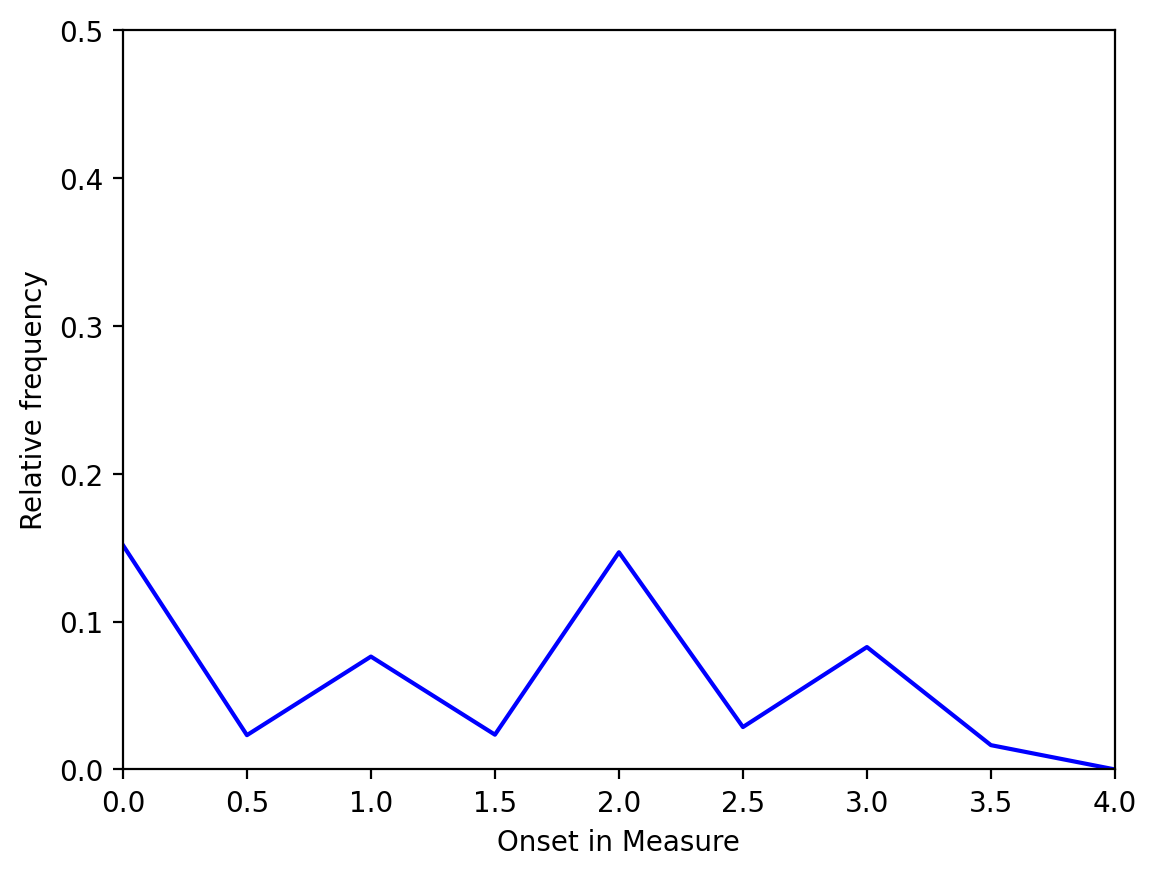

In [221]:
subset = rhythm_data_df_part[rhythm_data_df_part['staff'] == 'treble']
# subset2 = rhythm_data_df_part[rhythm_data_df_part['staff'] == 'bass']
# pd.concat([rhythm_data_df_part.head(50), rhythm_data_df_part.tail(4)], axis = 0)


def extract_onset_in_measure(subset):
    ## STUDENT SECTION -  ##
    return subset[(subset['event_type'] == "sounded") & (subset['tie_info'] != "tie_stop")]['onset_in_measure']
    ## END STUDENT SECTION ##

onsets = extract_onset_in_measure(subset)
helpers_onset_dist(onsets, 4) # graphing function

In [205]:
rhythm_data_df_part = pd.DataFrame(rhythm_data_list["3/4"], columns=['staff', 'measure_number', 'event_type', 'onset_in_measure', 'onset_in_score', 'duration', 'tie_info'])


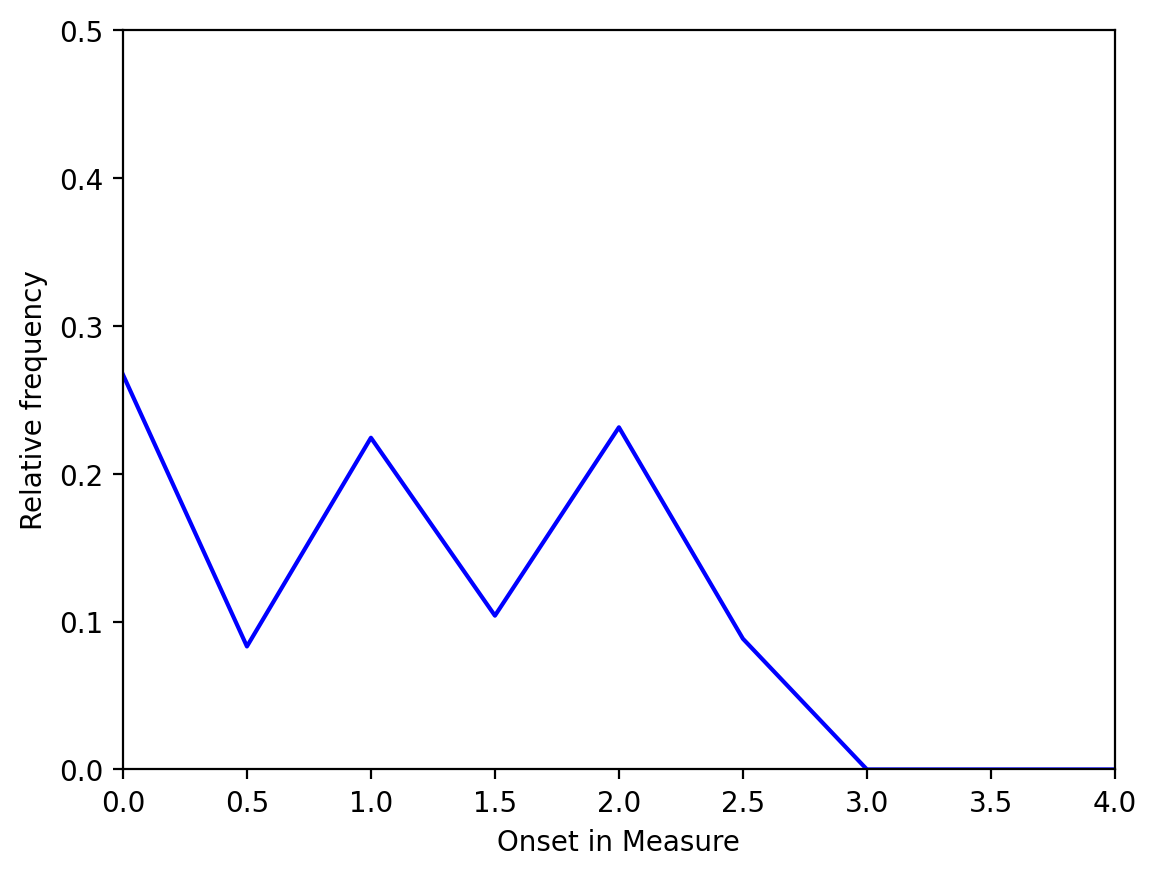

In [206]:
subset = rhythm_data_df_part[rhythm_data_df_part['staff'] == 'treble']



onsets = extract_onset_in_measure(subset)
helpers_onset_dist(onsets, 4) # graphing function